### bd CPS graph basic labor market indicators

bd_CPS_grapher.ipynb

January 27, 2019

Brian Dew, brian.w.dew@gmail.com, twitter: @bd_econ

Requires: `cpsYYYY.ft`, where `YYYY` is the year, for each year in year_range.

____

Notes:

Several [open issues](https://github.com/bdecon/econ_data/issues) on GitHub. This code needs to do four things: 1) read and aggregate CPS data as instructed (one month, three months, one year, two years); 2) Apply some pre-specified calculations, such as the employment-to-population ratio, unemployment rate, usual earnings at various percentiles, etc.; 3) apply adjustments after the fact, such as moving average, or adjustment for inflation; and 4) allow for collecting data on multiple groups during each read cycle. 

Once the collected data are prepared, use matplotlib to generate nice-looking line plots. 



The [categorization](https://www.frbatlanta.org/chcs/human-capital-currents/2015/0612-measuring-labor-market-status-using-basic-data.aspx) of those not in the labor force is provided by the Federal Reserve Bank of Atlanta. 

Useful [pseudocode](https://www.kansascityfed.org/research/kcdc/cps/coreinfo/pseudocode/hrswk) for various CPS-based calculations is provided by the Federal Reserve Bank of Kansas City.

In [1]:
# Preliminaries
%matplotlib inline

# Import packages
import os, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Graph settings
plt.style.use('seaborn-white')
plt.rc('axes', edgecolor='white') # Hide the axes
plt.rc('axes', axisbelow=True)
plt.rcParams.update({'axes.titlesize': 'x-large'})

os.chdir('/home/brian/Documents/CPS/data/clean/')

# Recession start and end months, from NBER
rec_dt = [('2001-04-01', '2001-12-01'), ('2008-01-01', '2009-07-01')]

# Years of bd CPS data
year_range = range(1994, 2019)

In [2]:
def cps_datetime(df, year):
    """Return DATE '1994-01-01' from MONTH and year"""
    df['DATE'] = [pd.to_datetime(f'{year}-{month}-01') 
                  for month in df.index]
    return df 

In [3]:
def calc_specs(calc_type, query_str):
    
    d = {}
    
    fcols2 = re.findall(' ([A-Z]+) ', query_str)
    
    #Default columns to keep in initial data read
    d['filter_cols'] = ['LMSTAT', 'BASICWGT', 'MONTH'] + fcols2

    if calc_type == 'epop':
        d['tvars'] = {'EMPL': (lambda x: np.where((x['EMP']==1),  
                                                   x['BASICWGT'], 0))}
        d['calc_var'] = (lambda x: (x['EMPL'] / x['BASICWGT']))
        d['filter_cols'] = ['EMP', 'BASICWGT', 'MONTH'] + fcols2
        d['keep_cols'] = ['EMPL', 'BASICWGT', 'MONTH']
        
    if calc_type == 'epopcare':
        d['tvars'] = {'EMPL': (lambda x: np.where((x['EMP']==1) | 
                                                  (x['LMSTAT']=="NILF - Family"),  
                                                  x['BASICWGT'], 0))}
        d['calc_var'] = (lambda x: (x['EMPL'] / x['BASICWGT']))    
        d['filter_cols'] = ['EMP', 'LMSTAT', 'BASICWGT', 'MONTH'] + fcols2
        d['keep_cols'] = ['EMPL', 'BASICWGT', 'MONTH']
        
    if calc_type == 'ptecon':
        d['tvars'] = {'IPT': (lambda x: np.where(x['PTECON']==1, 
                                                 x['BASICWGT'], 0)),
                      'EMPL': (lambda x: np.where((x['EMP']==1),  
                                                   x['BASICWGT'], 0))}
        d['calc_var'] = (lambda x: (x['IPT'] / x['EMPL']))
        d['filter_cols'] = ['EMP', 'PTECON', 'BASICWGT', 'MONTH'] + fcols2
        d['keep_cols'] = ['EMPL', 'IPT', 'BASICWGT', 'MONTH']
        
    if calc_type == 'unemp':
        d['tvars'] = {'UNEMP': (lambda x: np.where(x['LMSTAT']=='Unemployed', 
                                                   x['BASICWGT'], 0)),
                      'LF': (lambda x: np.where(~x['LMSTAT'].str.contains('NILF'), 
                                                x['BASICWGT'], 0))}
        d['calc_var'] = (lambda x: (x['UNEMP'] / x['LF']))
        d['keep_cols'] = ['UNEMP', 'LF', 'MONTH']

    if calc_type == 'lfpr':
        d['tvars'] = {'LF': (lambda x: np.where(~x['LMSTAT'].str.contains('NILF'), 
                                                x['BASICWGT'], 0))}
        d['calc_var'] = (lambda x: (x['LF'] / x['BASICWGT']))
        d['keep_cols'] = ['LF', 'BASICWGT', 'MONTH']
        
    if calc_type == 'pop':       
        d['tvars'] = {}
        d['calc_var'] = lambda x: x['BASICWGT'] / 12.0
        d['filter_cols'] = ['BASICWGT', 'MONTH'] + fcols2
        d['keep_cols'] = ['BASICWGT', 'MONTH'] 
        
    if calc_type == 'union':
        d['tvars'] = {'TOT': lambda x: np.where(x['PEERNLAB'].isin([1, 2]), 
                                                x['PWORWGT'], 0),
                      'UNION': lambda x: np.where(x['PEERNLAB']==1, 
                                                  x['PWORWGT'], 0)}
        d['calc_var'] = (lambda x: (x['UNION'] / x['TOT']))
        d['filter_cols'] = ['PEERNLAB', 'PWORWGT', 'MONTH'] + fcols2
        d['keep_cols'] = ['UNION', 'TOT', 'MONTH']
        
    if calc_type == 'nilf_disill':
        d['keep_cols'] = ['DIS', 'BASICWGT', 'MONTH']
        d['tvars'] = {'DIS': lambda x: np.where(x['LMSTAT']=='NILF - Disabled/ill', 
                                                       x['BASICWGT'], 0)}
        d['calc_var'] = (lambda x: (x['DIS'] / x['BASICWGT']))
        
    if calc_type == 'nilf_school':
        d['keep_cols'] = ['SCHOOL', 'BASICWGT', 'MONTH']
        d['tvars'] = {'SCHOOL': lambda x: np.where(x['LMSTAT']=='NILF - School', 
                                                       x['BASICWGT'], 0)}
        d['calc_var'] = (lambda x: (x['SCHOOL'] / x['BASICWGT']))
        
    if calc_type == 'nilf_care':
        d['keep_cols'] = ['CARE', 'BASICWGT', 'MONTH']
        d['tvars'] = {'CARE': lambda x: np.where(x['LMSTAT']=='NILF - Family', 
                                                       x['BASICWGT'], 0)}
        d['calc_var'] = (lambda x: (x['CARE'] / x['BASICWGT']))
        
    if calc_type == 'nilf_retired':
        d['keep_cols'] = ['RET', 'BASICWGT', 'MONTH']
        d['tvars'] = {'RET': lambda x: np.where(x['LMSTAT']=='NILF - Retired', 
                                                       x['BASICWGT'], 0)}
        d['calc_var'] = (lambda x: (x['RET'] / x['BASICWGT']))
        
    if calc_type == 'nilf_discouraged':
        d['keep_cols'] = ['DISC', 'BASICWGT', 'MONTH']
        d['tvars'] = {'DISC': lambda x: np.where(x['LMSTAT']=='NILF - Discouraged',
                                                           x['BASICWGT'], 0)}
        d['calc_var'] = (lambda x: (x['DISC'] / x['BASICWGT']))
        
    
    return d

In [4]:
def binned_wage(group, wage_var, decile):
    """Return BLS-styled binned decile/percentile wage"""
    weight = 'PWORWGT'
    bin_size = 0.5 #($0.50)
    bins = list(np.arange(0.25, 300, bin_size))
    if wage_var == 'RWKWAGE':
        bin_size = 50 #($2.50)
        bins = list(np.arange(25, 3000, bin_size))
    bin_cut = lambda x: pd.cut(x[wage_var], bins, include_lowest=True)
    cum_sum = lambda x: x[weight].cumsum()
    dft = (group.sort_values(wage_var)
                .assign(WAGE_RANGE = bin_cut, CS = cum_sum))
    dec_point = dft[weight].sum() * decile
    dec_bin = (dft.iloc[(dft['CS'] - dec_point).abs().argsort()[:1]]
                  .WAGE_RANGE.values[0])
    wage_bins = list(dft['WAGE_RANGE'].unique())
    dec_loc = wage_bins.index(dec_bin)
    bin_below = dft[dft['WAGE_RANGE'] == wage_bins[dec_loc-1]].iloc[-1].CS
    bin_above = dft[dft['WAGE_RANGE'] == wage_bins[dec_loc]].iloc[-1].CS
    dec_value = ((((dec_point - bin_below) / 
                   (bin_above - bin_below)) * bin_size) + dec_bin.left)
    return dec_value

In [ ]:
def wage_calc(query_str, calc_type, decile):
    
    # Usual hourly earnings - real
    if calc_type == 'hourly_wage_real':
        wage_var = 'RHRWAGE'
    # Usual weekly earnings - real
    if calc_type == 'weekly_wage_real':
        wage_var = 'RWKWAGE'
    
    cps_dir = '/home/brian/Documents/CPS/data/'

    cps_files = pd.Series([pd.to_datetime(file[:5], format='%b%y') 
                           for file in os.listdir(cps_dir) 
                           if file.endswith('.dat')
                           and not file.startswith('cpsb')])

    dt_windows = [pd.date_range(end=mo, periods=12, freq='MS') 
                      for mo in cps_files.sort_values()[11:]]
    
    fcols2 = re.findall(' ([A-Z]+) ', query_str)
    
    filter_cols = ['YEAR', 'MONTH', wage_var, 'PWORWGT'] + fcols2

    cps_date = lambda x: pd.to_datetime(
        dict(year=x.YEAR, month=x.MONTH, day=1))
    df = pd.concat([
         (pd.read_feather(f'cps{year}.ft', columns=filter_cols)
            .query(query_str)
            .query('PWORWGT > 0 and {} > 0'.format(wage_var))
            .assign(DATE = cps_date)
            .drop(['YEAR', 'MONTH'], axis=1)) 
         for year in year_range])

    data = pd.Series()
    for dw in dt_windows:
        dec_wage = binned_wage(df[df['DATE'].isin(dw)], wage_var, decile)
        data[dw[-1]] = dec_wage

    return data

In [ ]:
def data_retriever(query_str, calc_type, decile=None):    
    
    if 'wage' not in calc_type:
        d = calc_specs(calc_type, query_str)
        
        data = (pd.concat(
            [(pd.read_feather(f'cps{year}.ft', columns=d['filter_cols'])
                .query(query_str)
                .assign(**d['tvars'])
                .filter(d['keep_cols'])
                .groupby('MONTH').sum()
                .pipe(cps_datetime, year)
                .set_index('DATE')
                .assign(FINAL = d['calc_var'])
                .FINAL) for year in year_range])
                ).rolling(12).mean().dropna()

    if 'wage' in calc_type:
        data = wage_calc(query_str, calc_type, decile)        
    
    return data    

In [ ]:
def labor_mkt_grapher(title, data, color):
    """Graph time series data from 1994 to present, with recession bars
       and the most recent monthly data point labeled and annotated."""
    if data.max() <= 1.0:
        ftype = 'pct'
    elif data.max() <= 2000.0:
        ftype = 'usd'
    else:
        ftype = 'people'
    if ftype == 'pct':
        data = data * 100.0
    spcr, spcr2 = (data.max() - data.min()) / 26, (data.max() - data.min()) / 40
    offset = pd.DateOffset(months=4)
    ax = data.plot(figsize=(8, 4), color=color)
    ax = plt.xlim(data.index[0] - offset, data.index[-1] + offset)
    ax = plt.title(title, loc='left')
    ax = plt.scatter([data.index[-1]], [data[-1]], color=color, s=25)
    for i, v in rec_dt:
        ax = plt.axvspan(i, v, fill=True, linewidth=0, color='gray', alpha=0.2)
    if ftype == 'pct':
        ax = plt.annotate(f'   {data[-1]: .1f}%', (data.index[-1], data[-1]-spcr2))
    elif ftype == 'usd':
        ax = plt.annotate(f'   ${data[-1]: .2f}', (data.index[-1], data[-1]-spcr2))
    else:
        ax = plt.annotate(f'   {int(data[-1]):,}', (data.index[-1], data[-1]-spcr2))        
    ax = plt.xlabel('Source: Current Population Survey microdata, 12-month moving average', ha='left', x=0)
    ax = plt.annotate(f'  {data.index[-1]:%b %Y}', (data.index[-1], data[-1]+spcr), 
                      fontweight='bold')

#### How to use

1) Define the filter query string, for example: `filters = '25 <= AGE <= 54 and FEMALE == 1'`.

2) Give a text name to the group defined above, `group = 'women age 25 to 54'`.

3) Select the calculation (see below), `calc_type = 'epop'`.

4) Customize the title, `title = f'Employed share of population, {group}'`.

5) Call function, `data = bd_cps_data(filters, calc_type)`

6) Graph data (third argument is line color), `labor_mkt_grapher(title, data, 'blue')`


#### List of calc_type options

- `median_weekly_wage_real` (specify decile, e.g. data['10th'])
- `median_hourly_wage_real` (specify decile, e.g. data['10th'])
- `epop`
- `epopcare`
- `unrate`
- `lfpr`
- `pop`
- `union`
- `nilf_disill`
- `nilf_school`
- `nilf_care`
- `nilf_retired`
- `nilf_discouraged`

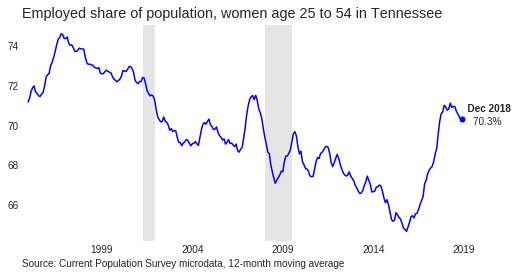

In [ ]:
# Example
query_str = '25 <= AGE <= 54 and FEMALE == 1 and STATE == "TN"'
group = 'women age 25 to 54 in Tennessee'
calc_type = 'epop'
decile = None
title = f'Employed share of population, {group}'
data = data_retriever(query_str, calc_type, decile)
labor_mkt_grapher(title, data, 'blue')

In [ ]:
# Example 2
filters = ' PRFTLF == 1'
group = 'full-time workers'
calc_type = 'weekly_wage_real'
decile = 0.1
title = f'First decile real hourly wage, {group}'
data = data_retriever(filters, calc_type, decile)
labor_mkt_grapher(title, data, 'red')

In [ ]:
# Example 3
filters = '25 <= AGE <= 34'
group = 'age 25 to 34'
calc_type = 'union'
decile = None
title = f'Union membership rate, {group}'
data = data_retriever(filters, calc_type, decile)
labor_mkt_grapher(title, data, 'green')

In [ ]:
# Example 4
ind_list = ['Manufacturing', 'Leisure and hospitality']
filters = '25 <= AGE <= 54 and INDGRP not in @ind_list'
group = 'age 25 to 54'
calc_type = 'ptecon'
decile = None
title = f'Involuntary part-time rate, {group}'
data = data_retriever(filters, calc_type, decile)
labor_mkt_grapher(title, data, 'blue')